In [2]:
import numpy as np
import scipy.io
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.optimize import fsolve
from scipy.optimize import leastsq
from scipy.signal import find_peaks
from scipy.integrate import solve_ivp
import scipy as sp

import warnings
warnings.filterwarnings('ignore')

# Plots setup 
from matplotlib import rc

rc('text', usetex=True)
plt.rcParams['text.latex.preamble'] = [
    r'\usepackage{tgheros}',    # helvetica font
    r'\usepackage{sansmath}',   # math-font matching  helvetica
    r'\sansmath'                # actually tell tex to use it!
    r'\usepackage{siunitx}',    # micro symbols
    r'\sisetup{detect-all}',    # force siunitx to use the fonts
]  
plt.rcParams.update({"font.size": 16})
plw = 0.6
pcs = 3
pms = 3
bfillc = [0.9,0.9,0.9]
plt.rcParams['axes.linewidth'] = plw
plt.rcParams['xtick.top'] = True
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['xtick.major.width'] = plw
plt.rcParams['xtick.minor.width'] = plw
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['xtick.major.size'] = 4.5
plt.rcParams['ytick.right'] = True
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['ytick.major.width'] = plw
plt.rcParams['ytick.minor.width'] = plw
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['ytick.major.size'] = 5
plt.rcParams["figure.figsize"] = (5,4)

from matplotlib.ticker import (MultipleLocator,
                               FormatStrFormatter,
                               AutoMinorLocator)


In [3]:
#Define Functions -> Free Energy
F=lambda VDstar, SIGMAprime, DmuE, Ctot, rhoL, Ceq, Vtot, :\
                                            +SIGMAprime*np.power((3*VDstar),2/3)*np.power((4*np.pi/Vtot),1/3) \
                                            -VDstar*(np.log((Ctot-rhoL*VDstar)/(Ceq*(1-VDstar)))+DmuE*((1-Ctot/Ceq))) # 
                                            #-rhoL*Cw/Mp*(1-VDstar)*(np.log(1-(Ctot-rhoL*VDstar)/(Cw*Mp*(1-VDstar))) \
                                            #-np.log(1-Ceq/(Cw*Mp))) #
                                                    
#Define Functions -> derivative
dFdV=lambda VDstar, SIGMAprime, DmuE, Ctot, rhoL, Ceq, Vtot, : \
                                            -DmuE*(1-Ctot/Ceq)-np.log((Ctot - rhoL * VDstar )/(Ceq - Ceq* VDstar)) \
                                            + (VDstar * (rhoL - Ctot))/((VDstar - 1) * (rhoL * VDstar - Ctot)) \
                                            + (2 * SIGMAprime*np.power((4*np.pi/Vtot),1/3))/(np.power(3*VDstar,(1/3)))

#Define Functions -> Free Energy in the macroscopic limit
Fmacro=lambda VDstar, SIGMAprime, DmuE, Ctot, Ceq, Vtot, : \
                                            +SIGMAprime*np.power((3*VDstar),2/3)*np.power((4*np.pi/Vtot),1/3) \
                                            -VDstar*(np.log((Ctot)/(Ceq))+DmuE*(1-Ctot/Ceq))

#Define Functions -> derivative in the macroscopic limit
dFdVmacro=lambda VDstar, SIGMAprime, DmuE, Ctot, Ceq, Vtot, : \
                                            -(1-Ctot/Ceq)*DmuE-np.log((Ctot)/(Ceq)) \
                                            + (2 * SIGMAprime*np.power((4*np.pi/Vtot),1/3))/(np.power(3*VDstar,(1/3)))

#Define Functions -> Critical Normalised Droplet Volume (macroscopic)
criticalVmacro=lambda SIGMAprime, DmuE, Ctot, Ceq, Vtot, : \
                                            1/3 * np.power(2*SIGMAprime*np.power(4*np.pi/Vtot,1/3) / (np.log(Ctot/Ceq) + DmuE*(1-Ctot/Ceq)),3)


# Redefine dFdV for optimization
# Error function
    # rhoL: density of the dense phase, constant with T
    # Vtot: total volume, constant in m^3
    # tpl: tuple of fitted parameters, tpl[0]: Gamma*Ceq, tpl[1]:sigma_prime
    # x,y: experimental data at constant T and different Ctot. x=VDstar, y=Ctot
ERR=lambda tpl, VDstar, Ctot, rhoL, Ceq, Vtot, T, SIGMAprime : \
                                -(tpl[0]*np.power(1/(273.15+T)-1/(273.15+50),1))*(1-Ctot/Ceq)-np.log((Ctot - rhoL * VDstar )/(Ceq - Ceq* VDstar)) \
                                + (VDstar * (rhoL - Ctot))/((VDstar - 1) * (rhoL * VDstar - Ctot)) \
                                + (2 * SIGMAprime *np.power((4*np.pi/Vtot),1/3))/(np.power(3*VDstar,(1/3)))





In [64]:
# DATA
# Temperature Ci,tot (g/L) VD* Vtot (L) ci,l,* (g/L) rhoL (g/L)
ETH_data=np.array([(15,3, 0.009942199,  3.8E-10, 0.9, 198),
                   (15, 2.4, 0.006407002, 3.8E-10, 0.9, 198),
                   (15, 1.14, 0.002375833, 3.8E-10, 0.9, 198),
                   (15, 3.6, 0.014660006, 3.8E-10, 0.9, 198),
                   (15, 1.8, 0.004770931, 3.8E-10, 0.9, 198)])




Nexperiments=np.shape(ETH_data)[0]

#Surface tension 
SIGMA=1E-7; #N/m

#N/m to dimensionless surface tension. 
MM=60000 #g/mol
R=8.314 #J/mol
TK=(273.15+ETH_data[:,0]) #K
RT=R*TK

SIGMAprime=SIGMA/RT/ETH_data[:,5]*MM/1E2 # J/dm^2

## Analysis of ETH dataset for Protein | fitted paramenters

In [1]:
# c=0
T=np.zeros(4)
RHOL=np.zeros(4)
Factor=np.zeros(4)
Ceqexp=np.zeros(4)
VT=np.zeros(4)

REPS=1000
MU0=np.zeros(REPS)

#Bootstrapping-like error calculation with random 
for REP in np.arange(0,REPS):
    #Randomise Initial Guess
    guess=[1]#np.random.rand(1,1,3)
    #choose 12 random experiments (with repetition)
    experiments=np.random.randint(0,Nexperiments,Nexperiments)   

    #least squares fitting
    #tplFitted=tuple of fitted parameters
    tplFitted,success=leastsq(ERR,guess,args=(ETH_data[experiments,2],ETH_data[experiments,1],ETH_data[experiments,5],ETH_data[experiments,4]\
                                          ,ETH_data[experiments,3],ETH_data[experiments,0],SIGMAprime),full_output=0,maxfev=1000,ftol=1E-15,gtol=1E-15)  
   

    MU0[REP]=tplFitted[0]

fig,ax = plt.subplots(1,1,figsize=(4,3))

ax.hist(MU0, bins = 'auto',alpha=0.6,color='blue')
ax.set_xlabel('${\Delta\mu^E_0}/{R}$',fontsize=26)
ax.set_xlim([np.average(MU0)-4*np.std(MU0), np.average(MU0)+4*np.std(MU0)])
plt.ticklabel_format(axis='both', style='sci', scilimits=(-2,2))
plt.savefig('panel_2_parameters', dpi=600, bbox_inches='tight');



NameError: name 'np' is not defined

## Analysis of ETH dataset protein Excess chemical potential as a function of T/C

[1.26490356e-10 1.26490356e-10 1.26490356e-10 1.26490356e-10
 1.26490356e-10]
[-1.12702865 -1.12702865 -1.12702865 -1.12702865 -1.12702865]


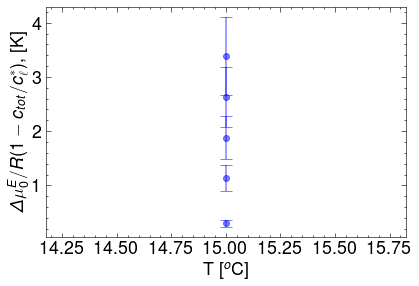

In [66]:
#figure
figure=plt.figure()
axes = figure.add_axes([0.1,0.1,1.,0.8])
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

DmuE=np.average(MU0)*(1/(273.15+ETH_data[:,0])-1/(273.15+50))

#Error
DmuEERROR=(np.std(MU0)*np.power(1/(273.15+ETH_data[:,0])-1/(273.15+50),1))

axes = figure.add_axes([0.1,0.1,1.,0.8]);
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.errorbar(ETH_data[:,0],DmuE*(1-ETH_data[:,1]/ETH_data[:,4]),yerr=DmuEERROR*(1-ETH_data[:,1]/ETH_data[:,4]),fmt="bo",alpha=0.5,capsize=6);
axes.set_ylabel('${\Delta\mu^E_0}/{R(1-c_{tot}/c^*_\ell)}$, [K]', fontsize=18);
axes.set_xlabel('T [$^o$C]',fontsize=18);
plt.savefig('DmuE_protein', dpi=600, bbox_inches='tight')
plt.show;

print(SIGMAprime)
print(DmuE)

## Analysis of ETH dataset for protein 3 Free energy profiles

3.0
2.4
1.14
3.6
1.8


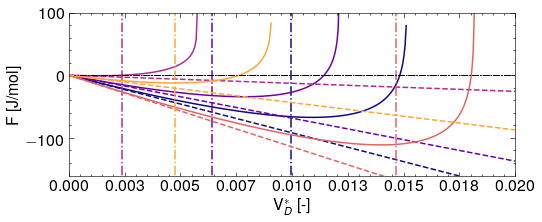

In [68]:
# Clean UP experimental parameters
T_exp=ETH_data[0,0]
Ctot_exp=ETH_data[:,1]
VDstar_exp=ETH_data[:,2]
Vtot_exp=ETH_data[0,3]
Ceq_exp=ETH_data[0,4]
rhoL_exp=ETH_data[0,5]

#value of fitted parameters in experimental conditions 
SIGMAprime_exp=SIGMAprime[0]

DmuE_exp=DmuE[0]
#parameters
BARRIER=np.zeros([Nexperiments])
CRITICAL_VOLUME=np.zeros([Nexperiments])
BARRIER_macro=np.zeros([Nexperiments])
CRITICAL_VOLUME_macro=np.zeros([Nexperiments])


fig, axs = plt.subplots(1,1,figsize=(8,3),sharex=True,gridspec_kw={'hspace': 0})

VDstar_v=np.linspace(0,0.05,1000)
cc=0

color=iter(cm.plasma(np.linspace(0,1,1+np.size(Ctot_exp))))   
# Cycle over Concentrations
for j in np.arange(0,np.size(Ctot_exp)):
    guess=1E-8
    c=next(color)
        
        
    print(Ctot_exp[j])
        
    # Find zeros of dFdV with fixed parameters (gamma and DmuE) => Critical VDstar
    CRITICAL_VOLUME[j],success=leastsq(dFdV,guess,args=(SIGMAprime_exp, DmuE_exp, Ctot_exp[j], rhoL_exp, Ceq_exp, Vtot_exp),full_output=0,maxfev=1000,ftol=1E-15,gtol=1E-15)  
    
    # Compute Free energy barrier   
    BARRIER[j]= R*(273.15+T_exp) * F(CRITICAL_VOLUME[j],SIGMAprime_exp, DmuE_exp, Ctot_exp[j], rhoL_exp, Ceq_exp, Vtot_exp) 
       
    # Plot 
    axs.plot([VDstar_exp[cc],VDstar_exp[cc]],[-700,500],'-.',c=c)
    axs.plot(VDstar_v,R*(273.15+T_exp) * F(VDstar_v,SIGMAprime_exp, DmuE_exp, Ctot_exp[j], rhoL_exp, Ceq_exp, Vtot_exp),c=c)  
    axs.plot([0,0.04],[0,0],'k-.',linewidth=1)
    axs.set_ylim([-160,100])
    axs.set_xlim([0,0.02]) 
    axs.plot(VDstar_v,R*(273.15+T_exp)*Fmacro(VDstar_v,SIGMAprime_exp, DmuE_exp, Ctot_exp[j], Ceq_exp, Vtot_exp),'--',c=c)  
    axs.set_ylabel('F [J/mol]')
    cc=cc+1
        
axs.set_xlabel('V$_D^*$ [-]')
axs.xaxis.set_major_formatter(FormatStrFormatter('% 1.3f'))   
plt.savefig('FittedFES_protein', dpi=600, bbox_inches='tight')





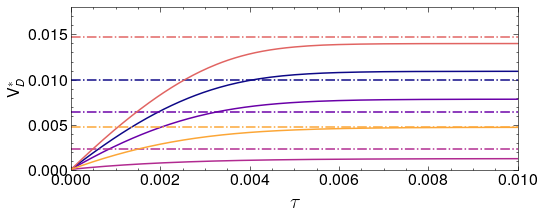

In [69]:
fig, axs = plt.subplots(1,1,figsize=(8,3),sharex=True,gridspec_kw={'hspace': 0})

cc=0
color=iter(cm.plasma(np.linspace(0,1,1+np.size(Ctot_exp))))   
# Cycle over Temperatures
for j in np.arange(0,np.size(Ctot_exp)):
    guess=1E-8
    c=next(color)
        
    dFdt = lambda t, s:  -1*dFdV(s,SIGMAprime_exp, DmuE_exp, Ctot_exp[j], rhoL_exp, Ceq_exp, Vtot_exp)
        
    t_eval = np.logspace(-10, -1.5, 1000)
    sol = solve_ivp(dFdt, [0, 2E-1], [1E-4], t_eval=t_eval)
    axs.plot([0, 5E-2],[VDstar_exp[cc],VDstar_exp[cc]],'-.',c=c)
    axs.plot(sol.t, sol.y[0],c=c)
    axs.set_ylim([0, 0.018])
    axs.set_xlim([0, 0.01])
    axs.set_ylabel('V$_D^*$')
    cc+=1

axs.set_xlabel('$\\tau$',fontsize=20)

axs.xaxis.set_major_formatter(FormatStrFormatter('% 1.3f'))        
plt.savefig('dynamics_protein', dpi=600, bbox_inches='tight')
plt.show()


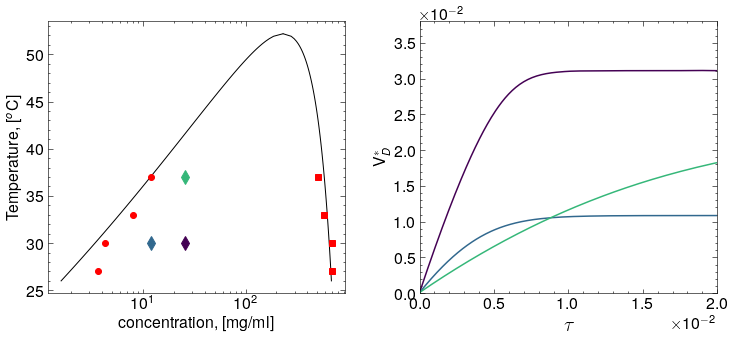

In [43]:
import pandas as pd



fig, axs = plt.subplots(1,2,figsize=(12,5),gridspec_kw={'wspace': 0.25})


df = pd.read_excel(r'DataUCST_MS.xlsx')
axs[0].plot(df.iloc[:,1],df.iloc[:,0],'-k',linewidth=1.)
axs[0].plot(df.iloc[:,2],df.iloc[:,0],'-k',linewidth=1.)
axs[0].plot(Ceq_exp,T_exp,'ro')
axs[0].plot(rhoL_exp,T_exp,'rs')
axs[0].set_xscale('log')
axs[0].set_xlabel('concentration, [mg/ml]')
axs[0].set_ylabel('Temperature, [$^o$C]')
color=iter(cm.viridis(np.linspace(0,1,1+np.size(Ctot_exp))))

i=1
j=2
c=next(color)
axs[0].plot(Ctot_exp[j],T_exp[i],'d',markersize=10,c=c)
dFdt = lambda t, s:  -1*dFdV(s,SIGMAprime_exp[i], DmuE_exp[i], Ctot_exp[j], rhoL_exp[i], Ceq_exp[i], Vtot_exp)
t_eval = np.logspace(-10, -1.5, 1000)
sol = solve_ivp(dFdt, [0, 2E-1], [1E-4], t_eval=t_eval)
axs[1].plot(sol.t, sol.y[0],c=c)
i=1
j=0
c=next(color)
axs[0].plot(Ctot_exp[j],T_exp[i],'d',markersize=10,c=c)
dFdt = lambda t, s:  -1*dFdV(s,SIGMAprime_exp[i], DmuE_exp[i], Ctot_exp[j], rhoL_exp[i], Ceq_exp[i], Vtot_exp)
t_eval = np.logspace(-10, -1.5, 1000)
sol = solve_ivp(dFdt, [0, 2E-1], [1E-4], t_eval=t_eval)
axs[1].plot(sol.t, sol.y[0],c=c)
i=3
j=2
c=next(color)
axs[0].plot(Ctot_exp[j],T_exp[i],'d',markersize=10,c=c)
dFdt = lambda t, s:  -1*dFdV(s,SIGMAprime_exp[i], DmuE_exp[i], Ctot_exp[j], rhoL_exp[i], Ceq_exp[i], Vtot_exp)
t_eval = np.logspace(-10, -1.5, 1000)
sol = solve_ivp(dFdt, [0, 2E-1], [1E-4], t_eval=t_eval)
axs[1].plot(sol.t, sol.y[0],c=c)
axs[1].set_ylim([0, 0.038])
axs[1].set_xlim([0, 0.02])
axs[1].set_ylabel('V$_D^*$')
axs[1].set_xlabel('$\\tau$',fontsize=20)

plt.ticklabel_format(axis='both', style='sci', scilimits=(-2,2))
plt.savefig('phase_diagram_dynamics', dpi=600, bbox_inches='tight')

fig.tight_layout()



IndexError: invalid index to scalar variable.

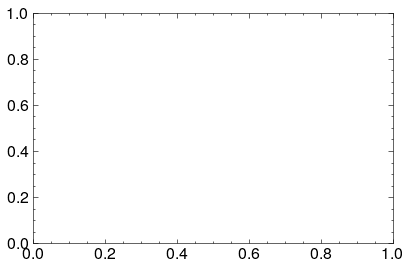

In [46]:
Ctot_lim=np.linspace(1,20,200)

BARRIER=np.zeros([4,100])
CRITICAL_VOLUME=np.zeros([4,200])
BARRIER_macroL=np.zeros([4,200])
CRITICAL_VOLUME_macroL=np.zeros([4,200])
CT_g,Ceq_g = np.meshgrid(Ctot_lim, Ceq_exp) 
CT_g,T_g   = np.meshgrid(Ctot_lim, T_exp) 

figure=plt.figure();
axes = figure.add_axes([0.1,0.1,1.,0.8]);

# Color for different Ts
color=iter(cm.Spectral(np.linspace(0,1,np.size(T_exp))))
    

# Cycle over Temperatures

for j in np.arange(0,np.size(Ctot_lim)):         
    CRITICAL_VOLUME_macroL[i,j]=criticalVmacro(SIGMAprime_exp[i], DmuE_exp[i], Ctot_lim[j], Ceq_exp[i], Vtot_exp)
        
    BARRIER_macroL[i,j]=R*(273.15+T_exp[i])*Fmacro(CRITICAL_VOLUME_macroL[i,j],SIGMAprime_exp[i], DmuE_exp[i], Ctot_lim[j], Ceq_exp[i], Vtot_exp)
        
    axes.plot(CT_g[i,:],BARRIER_macroL[i,:],'b-',alpha=0.8,c=c)
    axes.plot([Ceq_exp[i],Ceq_exp[i]],[0, 1E8],'--',c=c)

    
axes.set_yscale('log')
axes.set_xlabel('$c_{tot}$ [g/l]')
axes.set_ylabel('$\Delta{F}^*$ [J/mol]')
plt.show();